In [15]:
import xarray as xr
import numpy as np

# Load the uploaded NetCDF file
file_path = '/Users/yl3699/Downloads/sst.mon.ltm.1991-2020.nc'
data = xr.open_dataset(file_path, decode_times=False)

# Inspect the dataset to determine its structure
data


<xarray.Dataset> Size: 6MB
Dimensions:             (lat: 180, lon: 360, time: 12, nbnds: 2)
Coordinates:
  * lat                 (lat) float32 720B 89.5 88.5 87.5 ... -87.5 -88.5 -89.5
  * lon                 (lon) float32 1kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
  * time                (time) float64 96B -6.903e+05 -6.903e+05 ... -6.9e+05
Dimensions without coordinates: nbnds
Data variables:
    climatology_bounds  (time, nbnds) float64 192B ...
    sst                 (time, lat, lon) float32 3MB ...
    valid_yr_count      (time, lat, lon) float32 3MB ...
Attributes:
    title:                          COBE Sea Surface Temperature Analysis
    history:                        Created 2022/12/30 by doMonthLTMNC4
    platform:                       Analyses
    original_source:                http://near-goos1.jodc.go.jp/cgi-bin/1997...
    Conventions:                    CF-1.2
    institution:                    NOAA ESRL/PSD
    comment:                        recent values (w/i last year) may change ...
    dataset_title:                  COBE Sea Surface Temperature
    References:                     https://www.psl.noaa.gov/data/gridded/dat...
    not_missing_threshold_percent:  minimum 3% values input to have non-missi...

In [16]:
# Step 1: Remove seasonal cycle
sst = data['sst']  # Extract the SST variable

# Compute the monthly mean (climatology)
monthly_mean = sst.mean(dim='time')

# Remove the seasonal cycle by subtracting the monthly climatology
sst_anomalies = sst - monthly_mean

# Step 2: Apply latitude weighting
latitudes = data['lat']
latitude_weights = np.sqrt(np.cos(np.deg2rad(latitudes)))

# Expand weights to match SST dimensions (lat, lon)
weights = xr.DataArray(latitude_weights, dims=["lat"])  # Broadcasting handled automatically

# Apply weights to the SST anomalies
sst_weighted = sst_anomalies * weights

# Step 3: Handle missing values (masking invalid data)
sst_masked = sst_weighted.where(np.isfinite(sst_weighted), np.nan)

# Step 4: Format data matrix (time, lat * lon)
sst_matrix = sst_masked.stack(spatial=("lat", "lon")).transpose()

sst_matrix


<xarray.DataArray (spatial: 64800, time: 12)> Size: 3MB
array([[-0.00621929, -0.00621929, -0.00621929, ..., -0.00403961,
        -0.00613368, -0.00621929],
       [-0.00617584, -0.00617584, -0.00617584, ..., -0.0040662 ,
        -0.006098  , -0.00617584],
       [-0.00615118, -0.00615118, -0.00615118, ..., -0.00407269,
        -0.00608113, -0.00615118],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
  * time     (time) float64 96B -6.903e+05 -6.903e+05 ... -6.9e+05 -6.9e+05
  * spatial  (spatial) object 518kB MultiIndex
  * lat      (spatial) float32 259kB 89.5 89.5 89.5 89.5 ... -89.5 -89.5 -89.5
  * lon      (spatial) float32 259kB 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5

In [17]:
# Step 1: Singular Value Decomposition (SVD) for EOF computation
# Compute the covariance matrix of the (time, spatial) matrix
# Transpose the matrix to have spatial dimensions as columns
sst_array = sst_matrix.values.T  # Shape (time, spatial)
sst_array = np.nan_to_num(sst_array)  # Replace NaNs with 0 for covariance computation

# SVD avoids explicitly forming the large covariance matrix
U, S, Vt = np.linalg.svd(sst_array, full_matrices=False)  # Decompose (time, spatial)

# Step 2: Calculate explained variance
eigenvalues = S**2
total_variance = np.sum(eigenvalues)
explained_variance = eigenvalues / total_variance * 100  # As a percentage

# Step 3: Cumulative variance and the top 5 modes
explained_variance_cumulative = np.cumsum(explained_variance)

# Extract the top 5 modes
top_5_explained_variance = explained_variance[:5]
top_5_cumulative_variance = explained_variance_cumulative[:5]

(top_5_explained_variance, top_5_cumulative_variance)


(array([9.3167259e+01, 3.7314734e+00, 2.3870897e+00, 5.0793755e-01,
        9.1500275e-02], dtype=float32),
 array([93.16726 , 96.898735, 99.28583 , 99.79376 , 99.88526 ],
       dtype=float32))

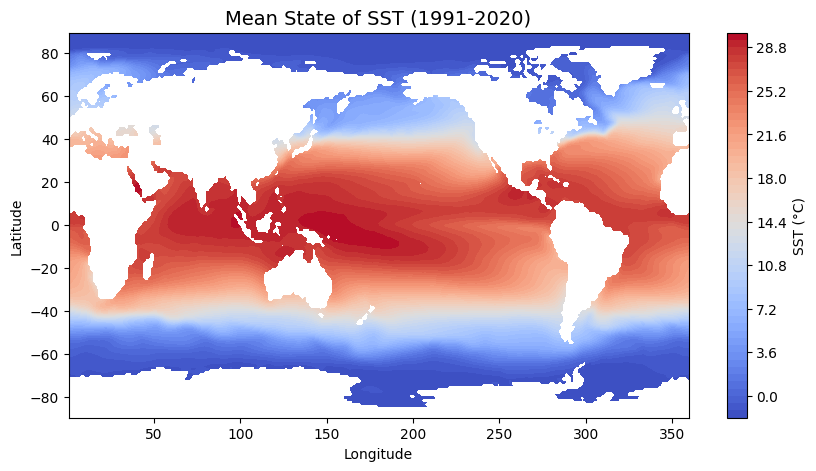

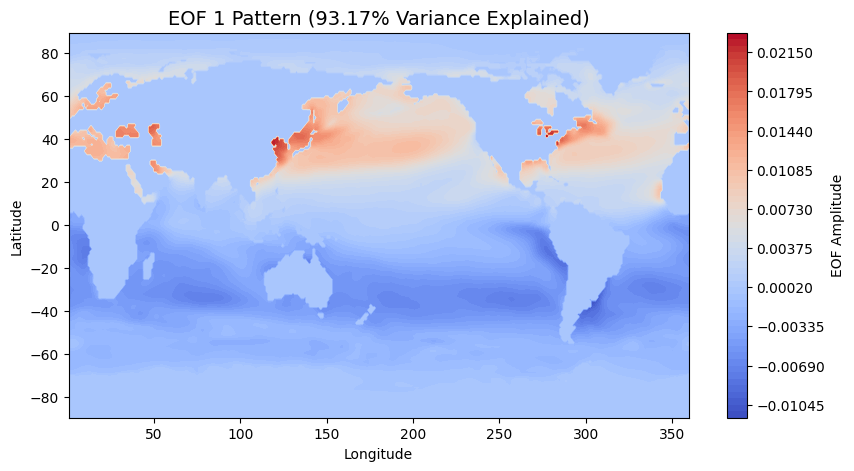

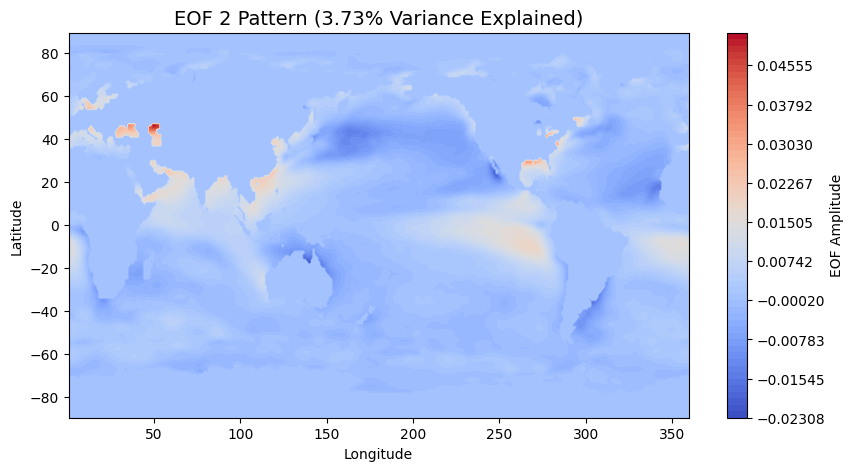

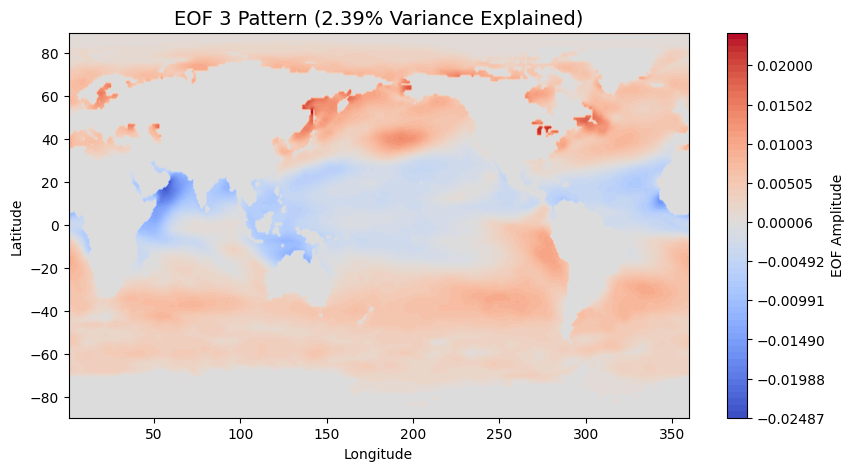

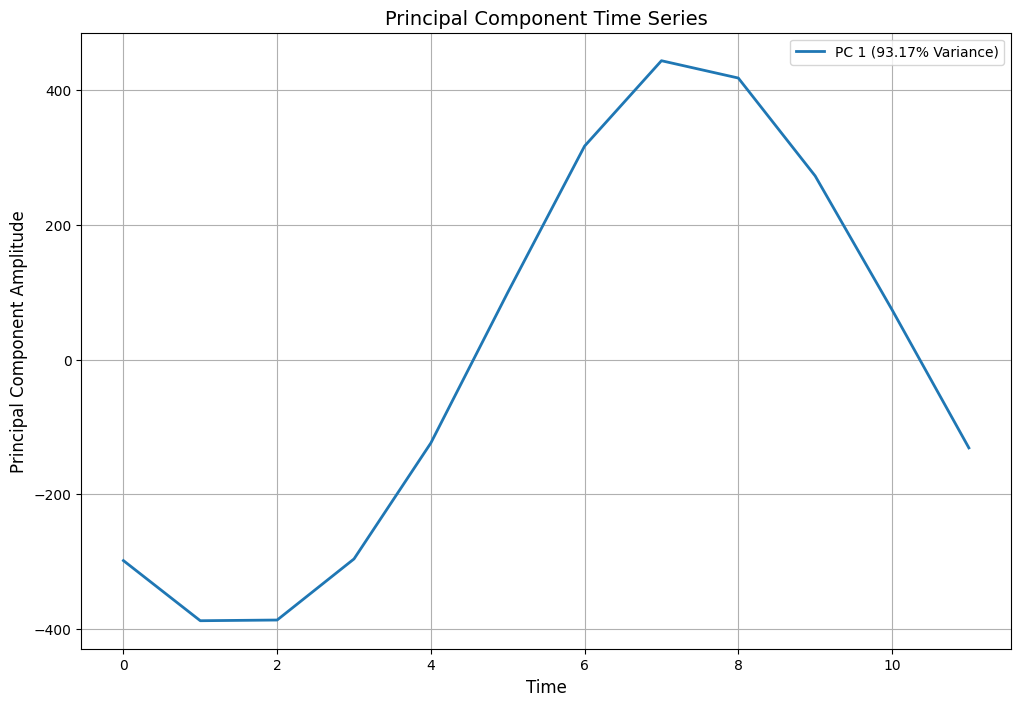

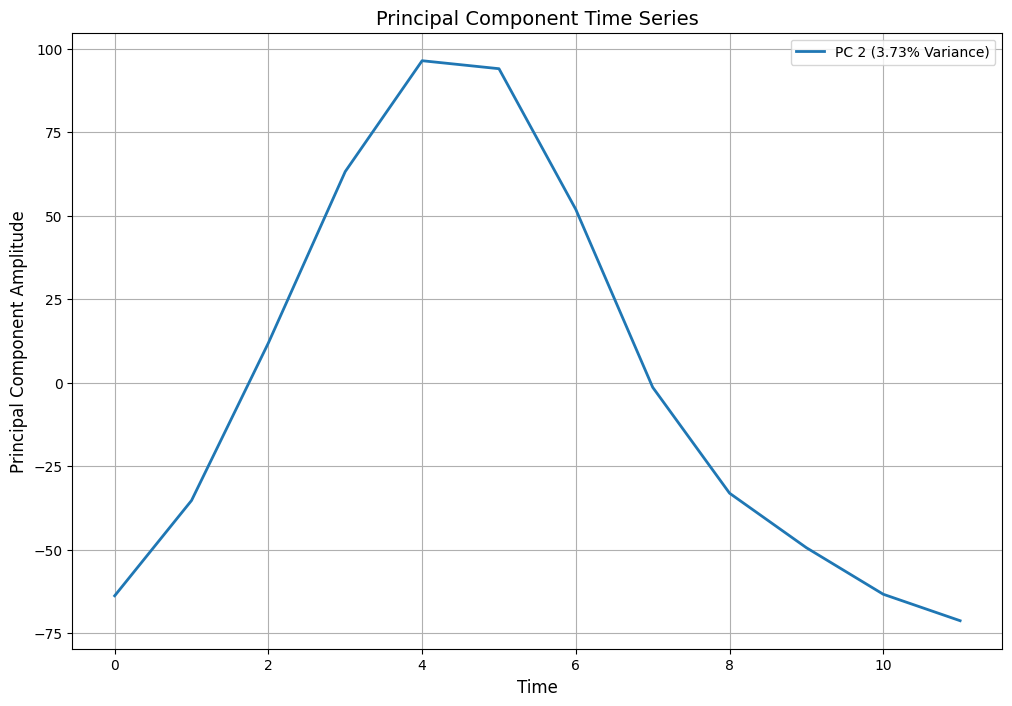

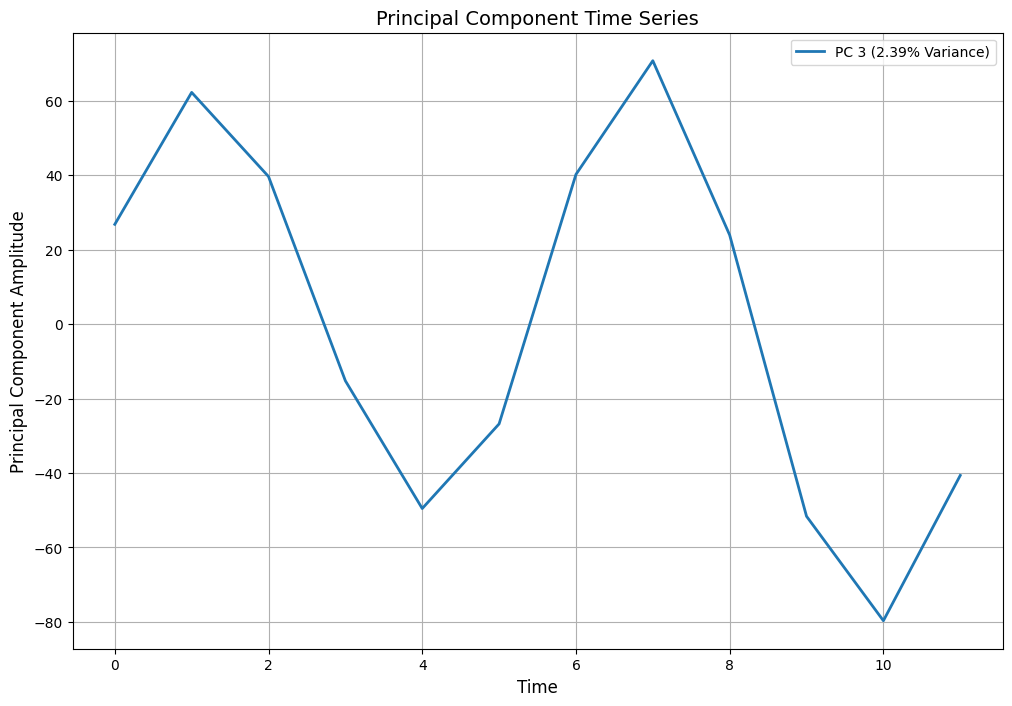

In [21]:
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from cartopy.feature import COASTLINE

# Prepare data for plotting
mean_state = monthly_mean  # Long-term mean
eofs = Vt[:3, :]  # First 3 EOF patterns
pcs = U[:, :3] * S[:3]  # Associated PCs

# Prepare grids for EOF maps
lon, lat = np.meshgrid(data['lon'], data['lat'])

# 1. Plot Mean State Map
plt.figure(figsize=(10, 5))
plt.contourf(lon, lat, mean_state.values, levels=60, cmap="coolwarm")
plt.colorbar(label="SST (°C)")
plt.title("Mean State of SST (1991-2020)", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# 2. Plot First 3 EOF Patterns
for i in range(3):
    eof_pattern = eofs[i, :].reshape(len(data['lat']), len(data['lon']))

    plt.figure(figsize=(10, 5))
    levels = np.linspace(eof_pattern.min(), eof_pattern.max(), 60)
    plt.contourf(lon, lat, eof_pattern, levels=levels, cmap="coolwarm")
    plt.colorbar(label="EOF Amplitude")
    plt.contour(lon, lat, eof_pattern, levels=np.linspace(-1, 1, 10), colors="k")
    plt.title(f"EOF {i+1} Pattern ({explained_variance[i]:.2f}% Variance Explained)", fontsize=14)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()
    
# 3. Plot PCs Time Series

for i in range(3):
    plt.figure(figsize=(12, 8))
    plt.plot(pcs[:, i], label=f"PC {i+1} ({explained_variance[i]:.2f}% Variance)", linewidth=2)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Principal Component Amplitude", fontsize=12)
    plt.title("Principal Component Time Series", fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()

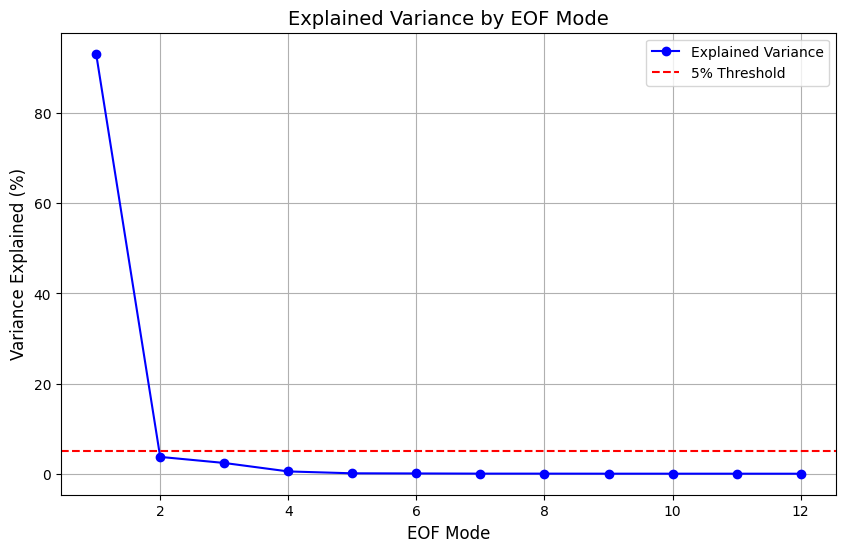

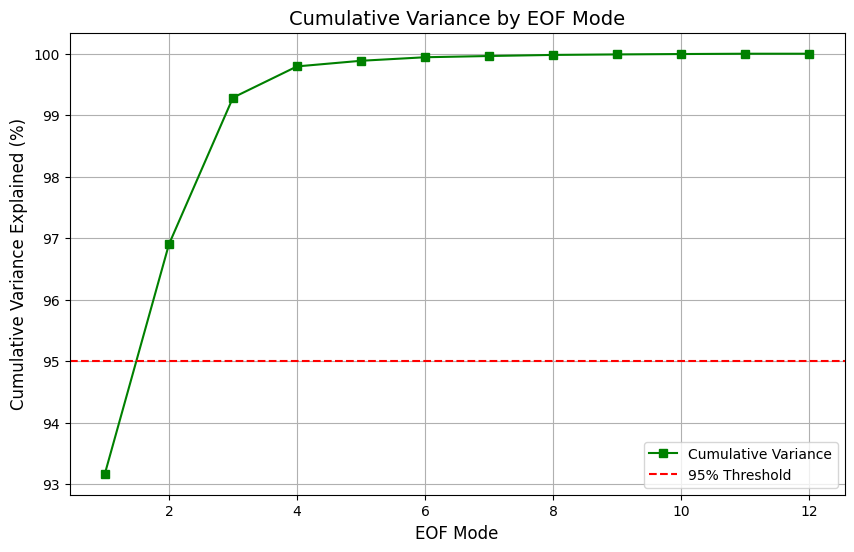

In [13]:
# Plot explained variance 
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', label='Explained Variance', color='blue')
plt.axhline(y=5, color='r', linestyle='--', label='5% Threshold')
plt.title('Explained Variance by EOF Mode', fontsize=14)
plt.xlabel('EOF Mode', fontsize=12)
plt.ylabel('Variance Explained (%)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Plot cumulative variance 
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_cumulative) + 1), explained_variance_cumulative, marker='s', label='Cumulative Variance', color='green')
plt.axhline(y=95, color='r', linestyle='--', label='95% Threshold')
plt.title('Cumulative Variance by EOF Mode', fontsize=14)
plt.xlabel('EOF Mode', fontsize=12)
plt.ylabel('Cumulative Variance Explained (%)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


In [10]:
# Step 1: Test statistical significance using North's Rule of Thumb
# The rule states: lambda_error = lambda * sqrt(2 / (effective_sample_size))
effective_sample_size = sst_array.shape[0]  # Number of time samples (time dimension)
eigenvalue_error = eigenvalues * np.sqrt(2 / effective_sample_size)

# Identify significant modes (if eigenvalues' error bars don't overlap)
significant_modes = []
for i in range(len(eigenvalues)):
    is_significant = True
    for j in range(len(eigenvalues)):
        if i != j:
            overlap = abs(eigenvalues[i] - eigenvalues[j]) <= (eigenvalue_error[i] + eigenvalue_error[j])
            if overlap:
                is_significant = False
                break
    if is_significant:
        significant_modes.append(i + 1)  # 1-based indexing for EOF modes

# Display significant modes
significant_modes


[1, 4, 12]